## DEFINING A COMPOSITE MODEL FOR MODEL STACKING BY HAND

In stacking one blends the predictions of different regressors or
classifiers to gain, in some cases, better performance than naive
averaging or majority vote.

Here we illustrate how to build a two-model stack as an MLJ learning
network, which we export as a new stand-alone composite model
type `MyTwoStack`. This will make the stack that we build completely
re-usable (new data, new models) and means we can apply
meta-algorithms, such as performance evaluation and tuning to the
stack, exaclty as we would for any other model.

Our main purpose is to demonstrate the flexibility of MLJ's
composite model interface. Eventually, MLJ will provide built-in
composite types or macros to achieve the same results in a few lines,
which will suffice for routine stacking tasks.

After exporting our learning network as a composite model, we
instantiate the model for an application to the Ames House Price data
set.

### Basic stacking using out-of-sample base learner predictions

A rather general stacking protocol was first described in a [1992
paper](https://www.sciencedirect.com/science/article/abs/pii/S0893608005800231)
by David Wolpert. For a generic introduction to the basic two-layer
stack described here, see [this blog
post](https://burakhimmetoglu.com/2016/12/01/stacking-models-for-improved-predictions/)
of Burak Himmetoglu.

A basic stack consists of a number of base learners (two, in this
illustration) and single adjudicating model.

When a stacked model is called to make a prediction, the individual
predictions of the base learners are made the columns of an *input*
table for the adjudicating model, which then outputs the final
prediction. However, it is crucial to understand that the flow of
data *during training* is not the same.

The base model predictions used to train the adjudicating model are
*not* the predictions of the base learners fitted to all the
training data. Rather, to prevent the adjudicator giving too much
weight to the base learners with low *training* error, the input
data is first split into a number of folds (as in cross-validation),
a base learner is trained on each fold complement individually, and
corresponding predictions on the folds are spliced together to form
a full-length out-of-sample prediction. For illustrative purposes we
use just three folds. Each base learner will get three separate
machines, for training on each fold complement, and a fourth
machine, trained on all the supplied data, for use in the prediction
flow.

We build the learning network with dummy data at the source nodes,
so the reader can experiment with the network as it is built (by
calling `fit!` on nodes, and by calling the nodes themselves, as
they are defined). As usual, this data is not seen by the exported
composite model type, and the component models we choose are just
default values for the hyperparameters of the composition model.

In [1]:
using MLJ
using Plots
pyplot(size=(200*1.5, 120*1.5))
import Random.seed!
seed!(1234)

MersenneTwister(UInt32[0x000004d2]) @ 1002

Some models we will need:

In [2]:
linear = @load LinearRegressor pkg=MLJLinearModels
ridge = @load RidgeRegressor pkg=MultivariateStats; ridge.lambda = 0.01
knn = @load KNNRegressor; knn.K = 4
tree = @load DecisionTreeRegressor; min_samples_leaf=1
forest = @load RandomForestRegressor; forest.n_estimators=500
svm = @load SVMRegressor

SVMRegressor(C = 1.0,
             kernel = "rbf",
             degree = 3,
             gamma = "auto",
             coef0 = 0.0,
             shrinking = true,
             tol = 0.001,
             cache_size = 200.0,
             max_iter = -1,
             epsilon = 0.1,) @ 1…21

### Warm-up exercise: Define a model type to average predictions

Let's define a composite model type `MyAverageTwo` that
averages the predictions of two deterministic regressors. Here's the learning network:

In [3]:
X = source()
y = source(kind=:target)

model1 = linear
model2 = knn

m1 = machine(model1, X, y)
y1 = predict(m1, X)

m2 = machine(model2, X, y)
y2 = predict(m2, X)

yhat = 0.5*y1 + 0.5*y2

Node @ 1…56 = +(#44(predict(9…85, 1…89)), #44(predict(6…79, 1…89)))

And the macro call to define `MyAverageTwo` and an instance `average_two`:

In [4]:
avg = @from_network MyAverageTwo(regressor1=model1,
                                       regressor2=model2) <= yhat

Main.##498.MyAverageTwo(regressor1 = LinearRegressor(fit_intercept = true,
                                                     solver = nothing,),
                        regressor2 = KNNRegressor(K = 4,
                                                  algorithm = :kdtree,
                                                  metric = Distances.Euclidean(0.0),
                                                  leafsize = 10,
                                                  reorder = true,
                                                  weights = :uniform,),) @ 6…24

Evaluating this average model on the Boston data set, and comparing
with the base model predictions:

In [5]:
evaluate(linear, (@load_boston)..., measure=rms)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


(measure = MLJBase.RMS[rms],
 measurement = [6.27043909692021],
 per_fold = Array{Float64,1}[[3.228933170157543, 5.179807063697625, 5.1666956002014395, 4.363077879195278, 11.246554494934387, 5.141774806625128]],
 per_observation = Missing[missing],)

In [6]:
evaluate(knn, (@load_boston)..., measure=rms)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


(measure = MLJBase.RMS[rms],
 measurement = [8.99902285894363],
 per_fold = Array{Float64,1}[[8.2929980685085, 9.650573246605367, 10.194428333536859, 9.332731299673467, 10.364438830052729, 5.053638166799264]],
 per_observation = Missing[missing],)

In [7]:
evaluate(avg, (@load_boston)..., measure=rms)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


(measure = MLJBase.RMS[rms],
 measurement = [6.601768603910837],
 per_fold = Array{Float64,1}[[4.736234224776171, 6.352117922650071, 6.914005922833893, 6.119499278904448, 9.886781905233187, 3.964665142879417]],
 per_observation = Missing[missing],)

### Step 0: Helper functions:

To generate folds:

In [8]:
folds(data, nfolds) =
    partition(1:nrows(data), (1/nfolds for i in 1:(nfolds-1))...);

For example, we have:

In [9]:
f = folds(1:10, 3)

([1, 2, 3], [4, 5, 6], [7, 8, 9, 10])

In our learning network, the folds will depend on the input data,
which will be wrapped as a source node. We therefore need to
overload the `folds` function for nodes:

In [10]:
folds(X::AbstractNode, nfolds) = node(XX -> folds(XX, nfolds), X);

It will also be convenient to use the MLJ method `restrict(X, f, i)`
that restricts data `X` to the `i`th element (fold) of `f`, and
`corestrict(X, f, i)` that restricts to the corresponding fold
complement (the concatenation of all but the `i`th
fold).

For example, we have:

In [11]:
corestrict(string.(1:10), f, 2)

7-element Array{String,1}:
 "1" 
 "2" 
 "3" 
 "7" 
 "8" 
 "9" 
 "10"

Overloading these functions for nodes:

In [12]:
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> restrict(XX, ff, i), X, f);
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> corestrict(XX, ff, i), X, f);

All the other data manipulations we will need (`vcat`, `hcat`,
`MLJ.table`) are already overloaded to work with nodes.

### Step 1: Choose some test data (optional) and some component models (defaults for the composite model):

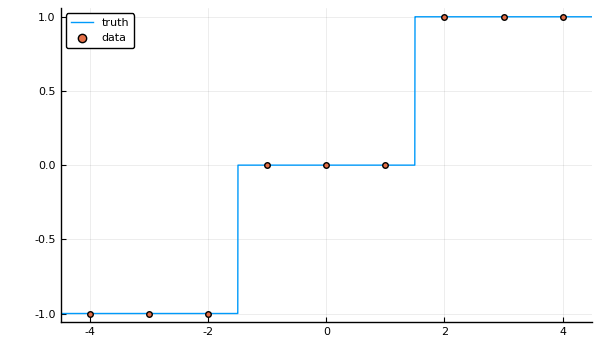

In [13]:
steps(x) = x < -3/2 ? -1 : (x < 3/2 ? 0 : 1)
x = Float64[-4, -1, 2, -3, 0, 3, -2, 1, 4]
Xraw = (x = x, )
yraw = steps.(x);
plt = plot(steps, xlim=(-4.5, 4.5), label="truth");
scatter!(deepcopy(plt), x, yraw, label="data")

Some models to stack:

In [14]:
model1 = linear
model2 = knn

KNNRegressor(K = 4,
             algorithm = :kdtree,
             metric = Distances.Euclidean(0.0),
             leafsize = 10,
             reorder = true,
             weights = :uniform,) @ 3…18

The adjudicating model:

In [15]:
judge = linear

LinearRegressor(fit_intercept = true,
                solver = nothing,) @ 1…30

### Step 2: Define the training nodes

Let's instantiate some input and target source nodes for the
learning network, wrapping the play data defined above:

Wrapped as source node:

In [16]:
X = source(Xraw)
y = source(yraw; kind=:target)

Source{:target} @ 1…92


Our first internal node represents the three folds (vectors of row
indices) for creating the out-of-sample predictions:

In [17]:
f = folds(X, 3)
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

Constructing machines for training `model1` on each fold-complement:

In [18]:
m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

NodalMachine @ 9…34 = machine(LinearRegressor @ 1…30, 1…07, 1…29)

Define each out-of-sample prediction of `model1`:

In [19]:
y11 = predict(m11, restrict(X, f, 1));
y12 = predict(m12, restrict(X, f, 2));
y13 = predict(m13, restrict(X, f, 3));

Splice together the out-of-sample predictions for model1:

In [20]:
y1_oos = vcat(y11, y12, y13);

Optionally, to check our network so far, we can fit and plot
`y1_oos`:

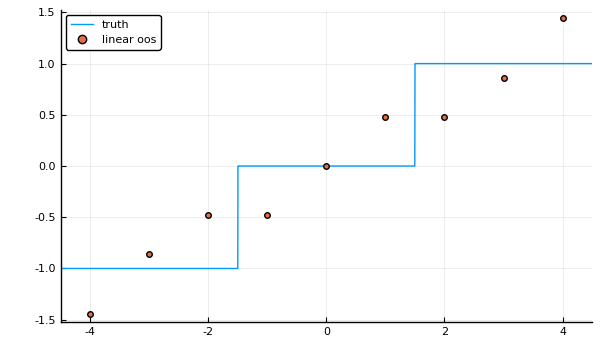

In [21]:
fit!(y1_oos, verbosity=0)
scatter!(deepcopy(plt), x, y1_oos(), label="linear oos")

We now repeat the procedure for the other model:

In [22]:
m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))
y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m22, restrict(X, f, 2));
y23 = predict(m23, restrict(X, f, 3));

And testing the knn out-of-sample prediction:

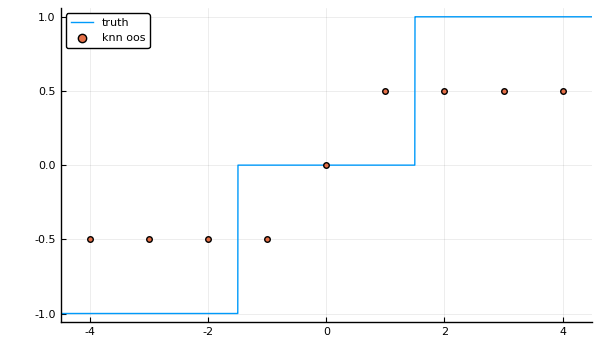

In [23]:
y2_oos = vcat(y21, y22, y23);
fit!(y2_oos, verbosity=0)
scatter!(deepcopy(plt), x, y2_oos(), label="knn oos")

Now that we have the out-of-sample base learner predictions, we are
ready to merge them into the adjudicator's input table and construct
the machine for training the adjudicator:

In [24]:
X_oos = MLJ.table(hcat(y1_oos, y2_oos))
m_judge = machine(judge, X_oos, y)

NodalMachine @ 1…36 = machine(LinearRegressor @ 1…30, 1…94, 1…92)

Are we done with constructing machines? Well, not quite. Recall that
when use the stack to make predictions on new data, we will be
feeding the adjudicator ordinary predictions on the base
learners. But so far, we have only defined machines to train the
base learners on fold complements, not on the full data, which we do
now:

In [25]:
m1 = machine(model1, X, y)
m2 = machine(model2, X, y)

NodalMachine @ 1…41 = machine(KNNRegressor @ 3…18, 2…78, 1…92)

### Step 3: Define nodes still needed for prediction

To obtain the final prediction, `yhat`, we get the base learner
predictions, based on training with all data, and feed them to the
adjudicator:

In [26]:
y1 = predict(m1, X);
y2 = predict(m2, X);
X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

Node @ 4…90 = predict(1…36, table(hcat(predict(1…14, 2…78), predict(1…41, 2…78))))

Let's check the final prediction node can be fit and called:

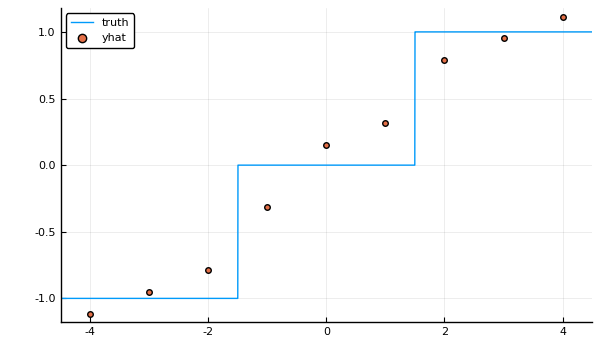

In [27]:
fit!(yhat, verbosity=0)
scatter!(deepcopy(plt), x, yhat(), label="yhat")

Although of little statistical significance here, we note that
stacking gives a lower *training* error than naive averaging:

In [28]:
e1 = rms(y1(), y())
e2 = rms(y2(), y())
emean = rms(0.5*y1() + 0.5*y2(), y())
estack = rms(yhat(), y())
@show e1 e2 emean estack;

e1 = 0.2581988897471611
e2 = 0.25
emean = 0.22126530078919587
estack = 0.19577994695380313


### Step 4: Export the learning network as a new model type

The learning network (less the data wrapped in the source nodes)
amounts to a specification of a new composite model type for
two-model stacks, trained with three-fold resampling of base model
predictions. Let's create the new type `MyTwoModelStack` (and an
instance):

In [29]:
instance = @from_network MyTwoModelStack(regressor1=model1,
                                         regressor2=model2,
                                         judge=judge) <= yhat

Main.##498.MyTwoModelStack(regressor1 = LinearRegressor(fit_intercept = true,
                                                        solver = nothing,),
                           regressor2 = KNNRegressor(K = 4,
                                                     algorithm = :kdtree,
                                                     metric = Distances.Euclidean(0.0),
                                                     leafsize = 10,
                                                     reorder = true,
                                                     weights = :uniform,),
                           judge = LinearRegressor(fit_intercept = true,
                                                   solver = nothing,),) @ 1…73

And this completes the definition of our re-usable stacking model type.

### Applying `MyTwoModelStack` to Ames House Price data

Without undertaking any hyperparameter optimization, we evaluate the
performance of a random forest and ridge regressor on the well-known
Ames House Prices data, and compare the performance of a stack
using the random forest and ridge regressors as base learners.

#### Data pre-processing

Here we use a reduced subset of the Ames House Price data set with
12 features:

In [30]:
X0, y0 = @load_reduced_ames;

Inspect scitypes:

In [31]:
s = schema(X0)
(names=collect(s.names), scitypes=collect(s.scitypes)) |> pretty

┌──────────────┬───────────────────┐
│ names        │ scitypes          │
│ Symbol       │ DataType          │
│ Unknown      │ Unknown           │
├──────────────┼───────────────────┤
│ OverallQual  │ OrderedFactor{10} │
│ GrLivArea    │ Continuous        │
│ Neighborhood │ Multiclass{25}    │
│ x1stFlrSF    │ Continuous        │
│ TotalBsmtSF  │ Continuous        │
│ BsmtFinSF1   │ Continuous        │
│ LotArea      │ Continuous        │
│ GarageCars   │ Count             │
│ MSSubClass   │ Multiclass{15}    │
│ GarageArea   │ Continuous        │
│ YearRemodAdd │ Count             │
│ YearBuilt    │ Count             │
└──────────────┴───────────────────┘


Coerce counts and ordered factors to continuous:

In [32]:
X1 = coerce(X0, :OverallQual => Continuous,
            :GarageCars => Continuous,
            :YearRemodAdd => Continuous,
            :YearBuilt => Continuous);

One-hot encode the multiclass:

In [33]:
hot_mach = fit!(machine(OneHotEncoder(), X1))
X = transform(hot_mach, X1);

┌ Info: Training Machine{OneHotEncoder} @ 1…80.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:172
┌ Info: Spawning 25 sub-features to one-hot encode feature :Neighborhood.
└ @ MLJModels /Users/anthony/Dropbox/Julia7/MLJ/MLJModels/src/builtins/Transformers.jl:601
┌ Info: Spawning 15 sub-features to one-hot encode feature :MSSubClass.
└ @ MLJModels /Users/anthony/Dropbox/Julia7/MLJ/MLJModels/src/builtins/Transformers.jl:601


Check the final scitype:

In [34]:
scitype(X)

ScientificTypes.Table{AbstractArray{Continuous,1}}

transform the target:

In [35]:
y1 = log.(y0)
y = transform(fit!(machine(UnivariateStandardizer(), y1)), y1);

┌ Info: Training Machine{UnivariateStandardizer} @ 1…75.
└ @ MLJ /Users/anthony/Dropbox/Julia7/MLJ/MLJ/src/machines.jl:172


#### Define the stack and compare performance:

In [36]:
avg = MyAverageTwo(regressor1=forest,
                   regressor2=ridge)


stack = MyTwoModelStack(regressor1=forest,
                        regressor2=ridge,
                        judge=linear)

function print_performance(model)
    e = evaluate(model, X, y,
                 resampling=CV(rng=1234, nfolds=8),
                 measure=rms,
                 verbosity=0)
    μ = round(e.measurement[1], sigdigits=5)
    ste = round(std(e.per_fold[1])/sqrt(8), digits=5)
    println("\n $model = $μ ± $(2*ste)")
end

all_models = [forest, ridge, avg, stack];

for model in all_models
    print_performance(model)
end;


 RandomForestRegressor @ 9…65 = 0.36791 ± 0.02438

 RidgeRegressor @ 1…44 = 0.33001 ± 0.02344

 MyAverageTwo @ 8…35 = 0.35857 ± 0.02344

 MyTwoModelStack @ 5…28 = 0.32979 ± 0.023


#### Tuning a stack

A standard abuse of data hygiene is to optimize stack component
model hyperparameters *separately* and then tune (using the same
resampling of the data) the adjudicating model hyperparameters with
the base learners fixed. Although more computationally expensive,
better performance might be expected by applying tuning to the stack
as a whole, either simultaneously, or in in cheaper sequential
steps. Since our stack is a stand-alone model, this is readily
implemented.

As a proof of concept, let's see how to tune one of the base model
hyperparameters, based on performance of the stack as a whole:

In [37]:
r = range(stack, :(regressor2.lambda), lower = 1, upper = 20, scale=:log)
tuned_stack = TunedModel(model=stack,
                         ranges=r,
                         tuning=Grid(),
                         measure=rms,
                         resampling=Holdout())

mach = fit!(machine(tuned_stack,  X, y), verbosity=0)
best_stack = fitted_params(mach).best_model
best_stack.regressor2.lambda

10.27808532802195

Let's evaluate the best stack using the same data resampling used to
the evaluate the assorted untuned models (now we are abusing data hygeine!):

In [38]:
print_performance(best_stack)


 MyTwoModelStack @ 1…12 = 0.3292 ± 0.02262


*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*